In [1]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
certifi                      2024.8.30
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
debugpy                      1.8.5
decorator                    5.1.1
exceptiongroup               1.2.2
executing                    2.1.0
filelock                     3.16.1
flatbuffers                  24.3.25
fsspec                       2024.9.0
gast                         0.6.0
google-pasta                 0.2.0
grpcio                       1.66.1
h5py                         3.11.0
idna                         3.10
importlib_metadata           8.5.0
ipykernel                    6.29.5
ipython                      8.27.0
jedi                         0.19.1
Jinja2                       3.1.4
joblib                       1.4.2
jupyter_client               8.6

20/9/2024

Script per andare a controllare se CUDA è stato installato (check che i driver siano andati a buon fine e tutto sia ok), e per testare le performance di un semplice modello su un dataset con e senza l'uso della gpu.

Per farlo sono andato sul web a scaricare iul driver di cuda e di cudnn.

La mia GPU del pc personale è NVIDIA T1200 Laptop GPU

In [1]:
!nvidia-smi 

Sat Oct 12 12:40:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA T1200 Laptop GPU      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P8              7W /   40W |     474MiB /   4096MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

In [3]:
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

CUDA available: True
Number of GPUs: 1


In [4]:
# Crea un tensore
x = torch.randn(3, 3)

# Sposta il tensore sulla GPU
if torch.cuda.is_available():
    x = x.to('cuda')

print(x)

tensor([[ 2.0299, -1.4311, -0.1700],
        [ 1.0307,  0.7661,  0.5978],
        [ 0.8392, -0.2288, -0.5565]], device='cuda:0')


In [5]:
import polars as pl
import pandas as pd

In [10]:
iris = pd.read_csv("Iris.csv")

In [11]:
for it in range (10):
    iris = pd.concat([iris,iris])

In [12]:
iris

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [13]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Carica il DataFrame
df = iris

# Prepara i dati
X = df.drop(columns=['Id', 'Species']).values
y = df['Species'].values

# Codifica le etichette
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Suddividi in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Converti in tensori
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [14]:
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 3)  # 3 classi di specie

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [15]:
def train_model(model, X_train, y_train, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(100):  # 100 epoche
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train.to(device))
        loss = criterion(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()

In [24]:
%%timeit -n 3 -r 3

device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpu = SimpleNN()
train_model(model_gpu, X_train_tensor, y_train_tensor, device_gpu)

1.56 s ± 5.38 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [25]:
%%timeit -n 3 -r 3

device_cpu = torch.device("cpu")
model_cpu = SimpleNN()
train_model(model_cpu, X_train_tensor, y_train_tensor, device_cpu)

10.4 s ± 577 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


Notiamo come i tempi di training dei due modelli siano molto diversi (circa 10 volte tanto senza gpu).
Risultati ottenuti con X_train_tensor di 122800 righe.

In [23]:
def evaluate_model(model, X_test, y_test, device):
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test.to(device))
        _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted.cpu() == y_test).sum().item() / len(y_test)
    return accuracy

accuracy_cpu = evaluate_model(model_cpu, X_test_tensor, y_test_tensor, device_cpu)
accuracy_gpu = evaluate_model(model_gpu, X_test_tensor, y_test_tensor, device_gpu)

print(f'Accuracy (CPU): {accuracy_cpu:.2f}')
print(f'Accuracy (GPU): {accuracy_gpu:.2f}')

Accuracy (CPU): 0.98
Accuracy (GPU): 0.99


### Testo con cifar100 (image classification)

Con CURSOR

100.0%


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Numero di immagini nel training set: 50000
Numero di immagini nel test set: 10000
Dimensioni di un'immagine: torch.Size([3, 32, 32])
Numero di classi: 100


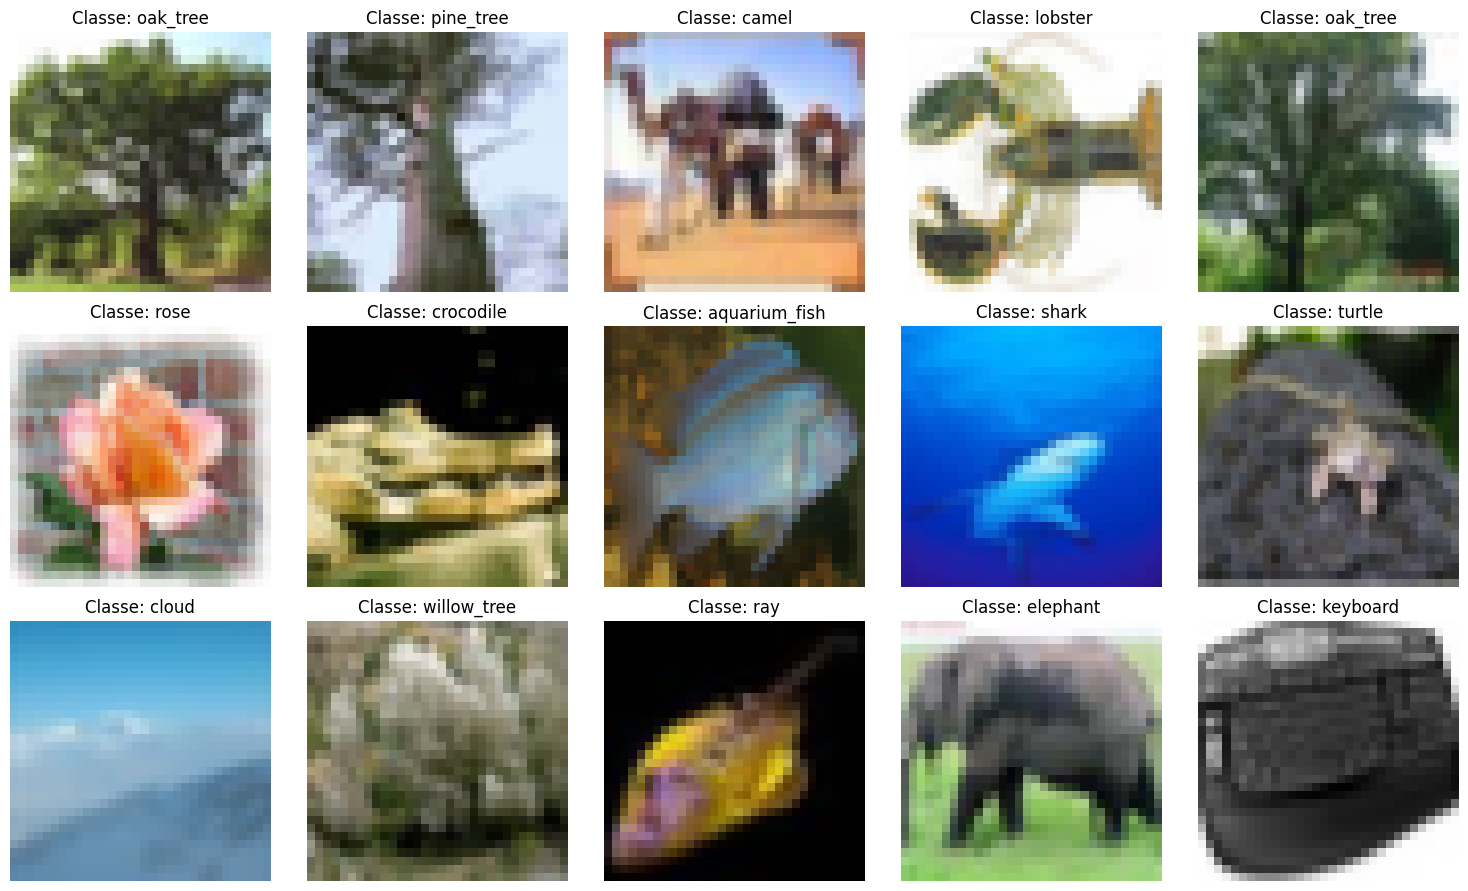

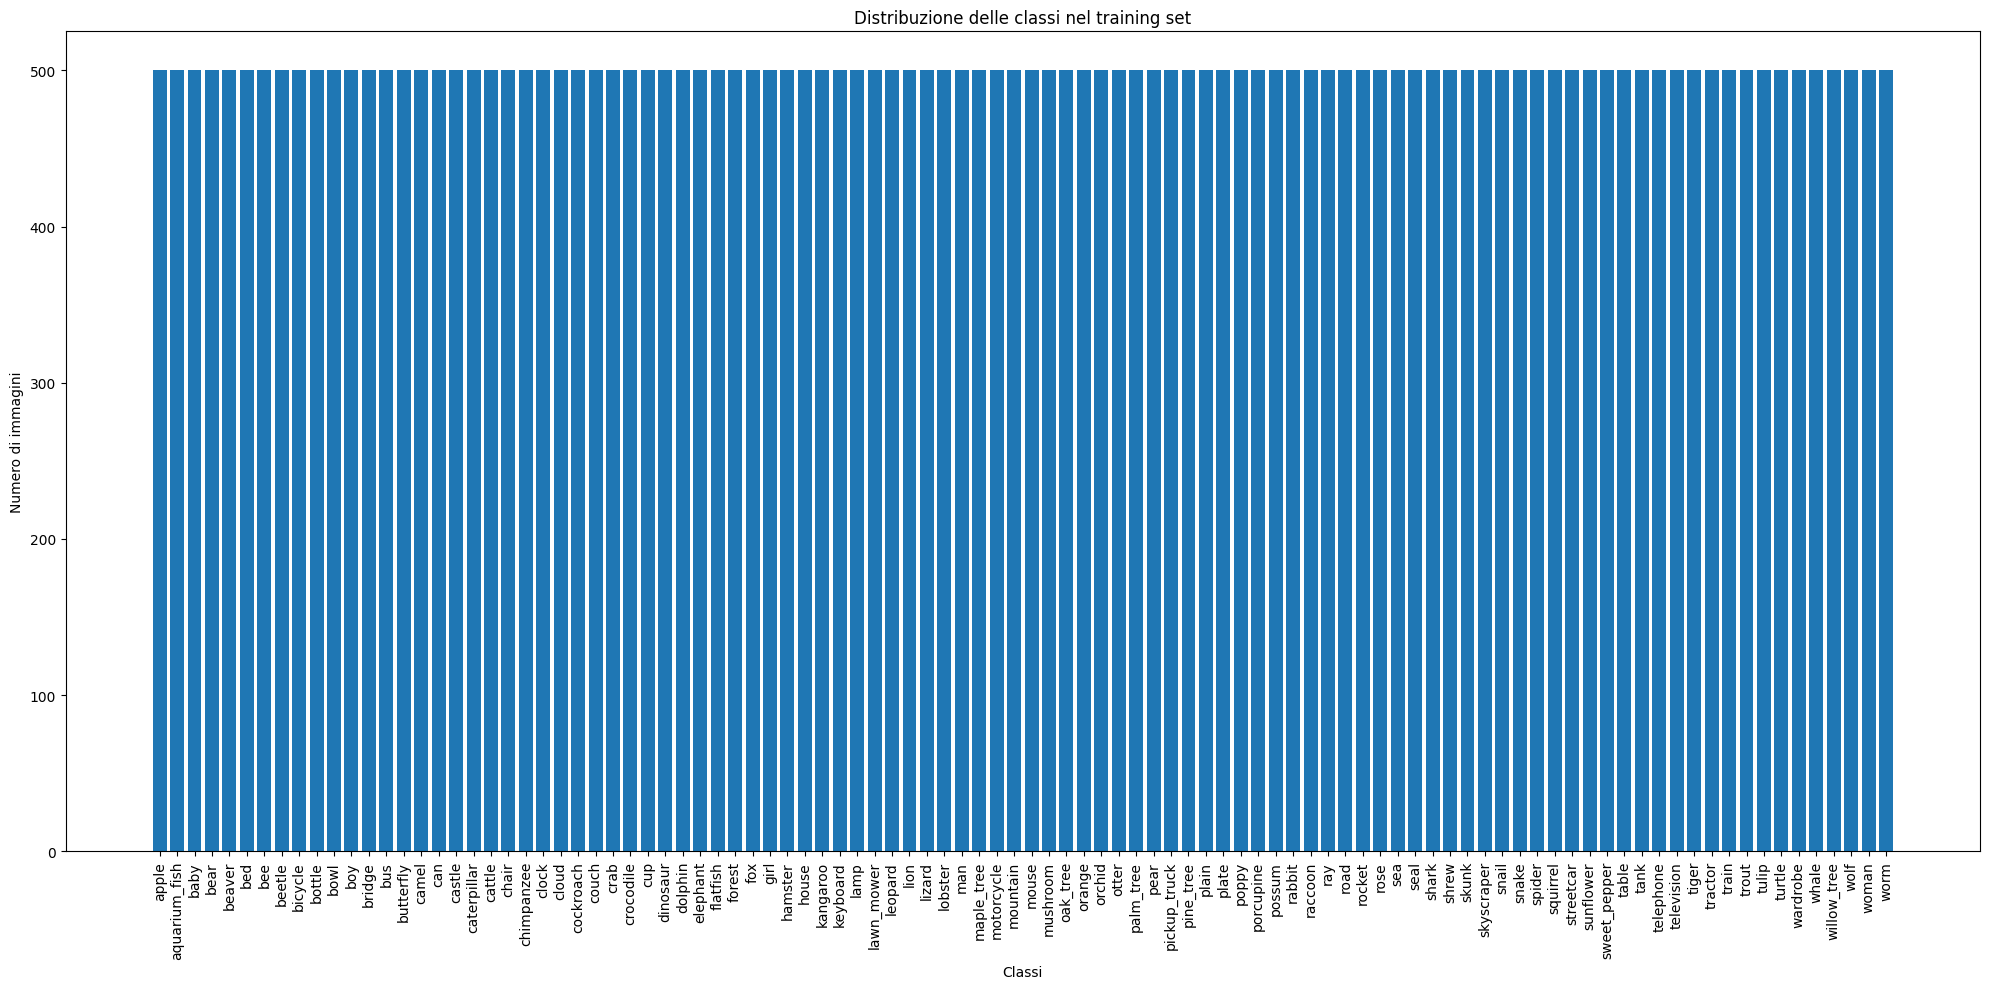

Media dei pixel per canale: tensor([0.5071, 0.4866, 0.4409])
Deviazione standard dei pixel per canale: tensor([0.2673, 0.2564, 0.2762])


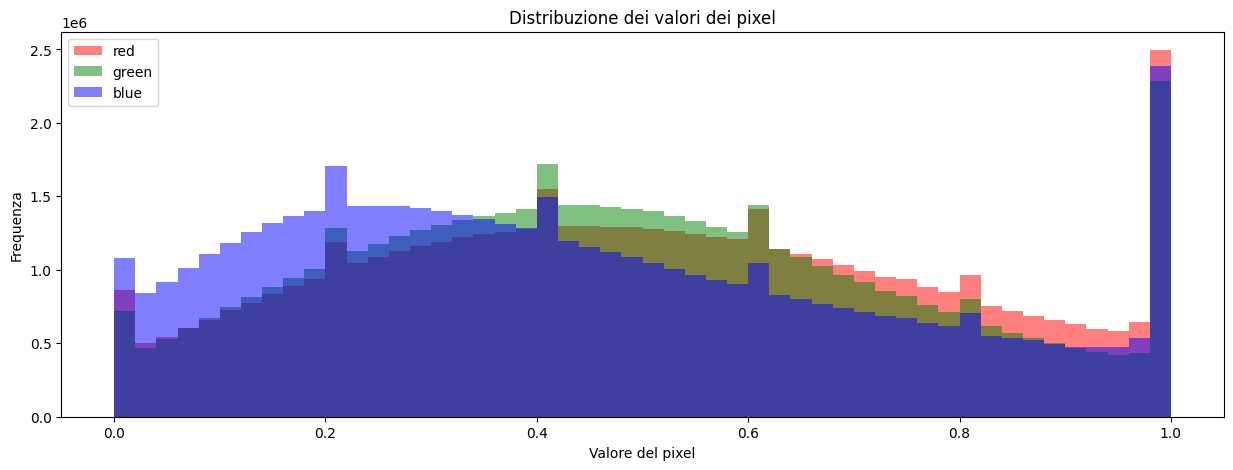

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Carica il dataset CIFAR-100
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

print(f"Numero di immagini nel training set: {len(trainset)}")
print(f"Numero di immagini nel test set: {len(testset)}")
print(f"Dimensioni di un'immagine: {trainset[0][0].shape}")
print(f"Numero di classi: {len(trainset.classes)}")

# Visualizza alcune immagini casuali
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(len(trainset))
    img, label = trainset[idx]
    ax.imshow(img.permute(1, 2, 0))  # Converti da CxHxW a HxWxC
    ax.set_title(f"Classe: {trainset.classes[label]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Conta il numero di immagini per ogni classe
class_counts = {cls: 0 for cls in trainset.classes}
for _, label in trainset:
    class_counts[trainset.classes[label]] += 1

# Visualizza la distribuzione delle classi
plt.figure(figsize=(20, 10))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Distribuzione delle classi nel training set")
plt.xlabel("Classi")
plt.ylabel("Numero di immagini")
plt.tight_layout()
plt.show()

# Calcola e visualizza la media e la deviazione standard dei pixel
all_images = torch.stack([img for img, _ in trainset])
mean = all_images.mean(dim=[0, 2, 3])
std = all_images.std(dim=[0, 2, 3])

print(f"Media dei pixel per canale: {mean}")
print(f"Deviazione standard dei pixel per canale: {std}")

# Visualizza la distribuzione dei valori dei pixel
plt.figure(figsize=(15, 5))
for i, color in enumerate(['red', 'green', 'blue']):
    plt.hist(all_images[:, i, :, :].numpy().flatten(), bins=50, alpha=0.5, color=color, label=color)
plt.title("Distribuzione dei valori dei pixel")
plt.xlabel("Valore del pixel")
plt.ylabel("Frequenza")
plt.legend()
plt.show()

In [18]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assumiamo che trainset e testset siano già stati definiti nella cella precedente
# Creiamo solo i DataLoader

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Definizione della CNN
class CIFAR100CNN(nn.Module):
    def __init__(self):
        super(CIFAR100CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 100)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

def train_cnn(model, trainloader, device, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.to(device)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.3f}')

def evaluate_cnn(model, testloader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training e valutazione su GPU
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpu = CIFAR100CNN()

start_time = time.time()
train_cnn(model_gpu, trainloader, device_gpu)
end_time = time.time()
print(f"Tempo di training su GPU: {end_time - start_time:.2f} secondi")

accuracy_gpu = evaluate_cnn(model_gpu, testloader, device_gpu)
print(f'Accuracy (GPU): {accuracy_gpu:.4f}')

# Training e valutazione su CPU
device_cpu = torch.device("cpu")
model_cpu = CIFAR100CNN()

start_time = time.time()
train_cnn(model_cpu, trainloader, device_cpu)
end_time = time.time()
print(f"Tempo di training su CPU: {end_time - start_time:.2f} secondi")

accuracy_cpu = evaluate_cnn(model_cpu, testloader, device_cpu)
print(f'Accuracy (CPU): {accuracy_cpu:.4f}')

print("Confronto delle prestazioni:")
print(f"Accuracy (GPU): {accuracy_gpu:.4f}")
print(f"Accuracy (CPU): {accuracy_cpu:.4f}")

Epoch 1, Loss: 4.046
Epoch 2, Loss: 3.498
Epoch 3, Loss: 3.222
Epoch 4, Loss: 3.043
Epoch 5, Loss: 2.909
Epoch 6, Loss: 2.806
Epoch 7, Loss: 2.715
Epoch 8, Loss: 2.642
Epoch 9, Loss: 2.580
Epoch 10, Loss: 2.520
Tempo di training su GPU: 147.63 secondi
Accuracy (GPU): 0.3943
Epoch 1, Loss: 4.033
Epoch 2, Loss: 3.516
Epoch 3, Loss: 3.245
Epoch 4, Loss: 3.068
Epoch 5, Loss: 2.926
Epoch 6, Loss: 2.817
Epoch 7, Loss: 2.716
Epoch 8, Loss: 2.630
Epoch 9, Loss: 2.572
Epoch 10, Loss: 2.517
Tempo di training su CPU: 317.62 secondi
Accuracy (CPU): 0.3951
Confronto delle prestazioni:
Accuracy (GPU): 0.3943
Accuracy (CPU): 0.3951


Vediamo che per il training ci mettiamo 150 sec con gpu e 300 con solo cpu (quindi 2 volte piu veloce con la gpu)

- proviamo con un altro modello

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Verifica e imposta il dispositivo CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Trasformazioni e caricamento dei dati
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Definizione del modello ResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Inizializzazione del modello, loss e ottimizzatore
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Funzione di training con early stopping
def train_model(model, trainloader, criterion, optimizer, num_epochs=50, early_stopping_threshold=0.01):
    model.train()
    prev_loss = float('inf')
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(trainloader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.3f}')
        
        # Early stopping
        if prev_loss - epoch_loss < prev_loss * early_stopping_threshold:
            print(f"Early stopping at epoch {epoch+1}")
            break
        prev_loss = epoch_loss

# Funzione di valutazione
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training del modello
train_model(model, trainloader, criterion, optimizer)

# Valutazione del modello
accuracy = evaluate_model(model, testloader)
print(f'Accuracy on test set: {accuracy:.4f}')

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 3.750
Epoch 2, Loss: 2.969
Epoch 3, Loss: 2.445
Epoch 4, Loss: 2.087
Epoch 5, Loss: 1.831
Epoch 6, Loss: 1.629
Epoch 7, Loss: 1.470
Epoch 8, Loss: 1.331
Epoch 9, Loss: 1.216
Epoch 10, Loss: 1.115
Epoch 11, Loss: 1.011
Epoch 12, Loss: 0.928
Epoch 13, Loss: 0.841
Epoch 14, Loss: 0.769
Epoch 15, Loss: 0.699
Epoch 16, Loss: 0.628
Epoch 17, Loss: 0.578
Epoch 18, Loss: 0.513
Epoch 19, Loss: 0.462
Epoch 20, Loss: 0.419
Epoch 21, Loss: 0.374
Epoch 22, Loss: 0.336
Epoch 23, Loss: 0.305
Epoch 24, Loss: 0.283
Epoch 25, Loss: 0.248
Epoch 26, Loss: 0.235
Epoch 27, Loss: 0.213
Epoch 28, Loss: 0.205
Epoch 29, Loss: 0.184
Epoch 30, Loss: 0.179
Epoch 31, Loss: 0.170
Epoch 32, Loss: 0.166
Epoch 33, Loss: 0.150
Epoch 34, Loss: 0.144
Epoch 35, Loss: 0.132
Epoch 36, Loss: 0.145
Early stopping at epoch 36
Accuracy on test set: 0.6552


Con questo modello l'accuratezza è maggiore.